In [1]:
!pip install statsmodels==0.14.5
!pip install matplotlib==3.10.3
!pip install sklearn==0.0
!pip install hurst==0.0.3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 184.4 MB/s eta 0:00:00

[notice] A new release of pip is available: 24.2 -> 25.2
[notice] To update, run: pip install --upgrade pip
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 167.3 MB/s eta 0:00:00
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.10.0
    Uninstalling matplotlib-3.10.0:
      Successfully uninstalled matplotlib-3.10.0

[notice] A new release of pip is available: 24.2 -> 25.2
[notice] To update, run: pip install --upgrade pip
  Preparing metadata (setup.py) ... done
  Created wheel for sklearn: filename=sklearn-0.0-py2.py3-none-any.whl size=1342 sha256=c85dfdc334728dcc160ae30650d67af128ee2a27dd9e0e613745453698e3dc83
  Stored in directory: /root/.cache/pip/wheels/b6/79/d0/1f349fd7f2d799c2260c1be479f993c546f3045238876a00f0
Successfully built sklearn

[notice] A new release of pip is available: 24.2 -> 25.2
[notice] To update, run: pip install --upgrade pip

[notice] A new 

In [2]:
from statsmodels.tsa.seasonal import seasonal_decompose, STL
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from dateutil.parser import parse
from dateutil.relativedelta import relativedelta 
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
from statsmodels.tsa.ar_model import AutoReg
from hurst import compute_Hc
from datetime import date, datetime
import os
from matplotlib.dates import MonthLocator, DateFormatter

In [3]:
#Set this to True if you want to see how this quarter's forecast is going with a cutoff of calendar year.
#Set it to False if you want forecasts to include data from this year
verify=True

In [4]:
# Function to remove the beginning of a string if it starts with "CVSS:3.1" or "CVSS:3.0"
def remove_cvss_prefix(vector):
    if vector is not np.NaN:
        return vector[8+1:]
    else:
        return vector

In [5]:
# Function to remove double quotes within a string
def remove_double_quotes(input_string):
    if input_string is not np.NaN:
        return input_string.replace('"', '')
    else:
        return input_string

In [6]:
# Import Data
df = pd.read_csv('NVD-Vulnerability-Volumes.csv', index_col=['Publication'], low_memory=False)
df.index = pd.to_datetime(df.index, errors='coerce').tz_localize(None)  # Convert index to datetime, handling errors
df['Count'] = 1

# Ensure 'v2 Vector' and 'v3 Vector' are of type object
df['v2 Vector'] = df['v2 Vector'].astype('object')
df['v3 Vector'] = df['v3 Vector'].astype('object')

df.tail()

,ID,ASSIGNER,DESCRIPTION,v2 CVSS,v2 Exploitability Score,v2 Vector,v3 CVSS,v3 Vector,v3 Exploitability Score,v2.3 CPE,CWE,VulnStatus,Count
Publication,,,,,,,,,,,,,
2025-09-24 21:15:32.493,CVE-2025-57324,cve@mitre.org,parse is a package designed to parse JavaScrip...,NaN,NaN,NaN,NaN,NaN,NaN,[],NaN,Received,1
2025-09-24 21:15:32.613,CVE-2025-59827,security-advisories@github.com,Flag Forge is a Capture The Flag (CTF) platfor...,NaN,NaN,NaN,8.2,CVSS:3.0/AV:N/AC:L/PR:N/UI:N/S:U/C:L/I:H/A:N,3.9,[],CWE-862,Received,1
2025-09-24 21:15:32.767,CVE-2025-59833,security-advisories@github.com,Flag Forge is a Capture The Flag (CTF) platfor...,NaN,NaN,NaN,7.5,CVSS:3.1/AV:N/AC:L/PR:N/UI:N/S:U/C:H/I:N/A:N,3.9,[],CWE-200,Received,1
2025-09-24 22:15:35.423,CVE-2025-10894,secalert@redhat.com,Malicious code was inserted into the Nx (build...,NaN,NaN,NaN,9.6,CVSS:3.1/AV:N/AC:L/PR:N/UI:R/S:C/C:H/I:H/A:H,2.8,[],CWE-506,Received,1
2025-09-24 22:15:35.597,CVE-2025-54520,psirt@amd.com,Improper Protection Against Voltage and Clock ...,NaN,NaN,NaN,NaN,NaN,NaN,[],CWE-1247,Received,1


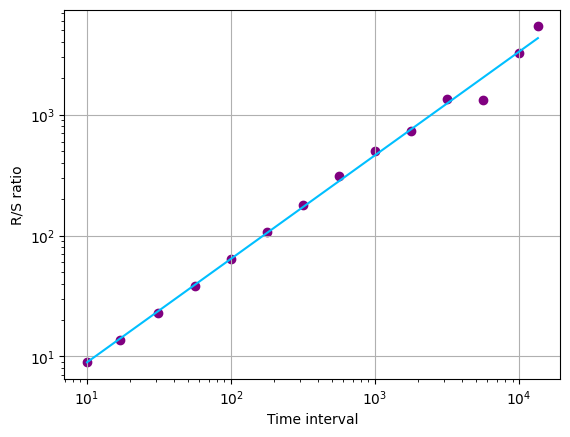

H=0.8574, c=1.2382


In [7]:
#Examine the data with the Hurst component to convinces ourselves this is possible (and lo0k at different timeframes of possibility)
H, c, data = compute_Hc(df['Count'].resample('D').sum(), kind='change',simplified=True)
# Plot
f, ax = plt.subplots()
ax.plot(data[0], c*data[0]**H, color="deepskyblue")
ax.scatter(data[0], data[1], color="purple")
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Time interval')
ax.set_ylabel('R/S ratio')
ax.grid(True)
plt.show()

print("H={:.4f}, c={:.4f}".format(H,c))

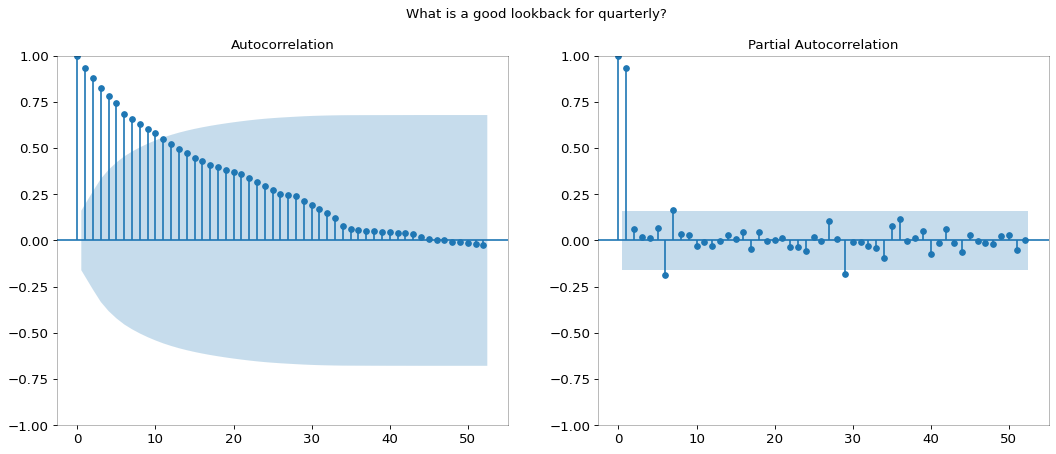

In [8]:
# Import Data
#df = all_vulns

# Draw Plot
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(16,6), dpi= 80)
plot_acf(df['Count'].resample('QE').sum().tolist(), ax=ax1, lags=52)
plot_pacf(df['Count'].resample('QE').sum().tolist(), ax=ax2, lags=52)

# Decorate
# lighten the borders
ax1.spines["top"].set_alpha(.3); ax2.spines["top"].set_alpha(.3)
ax1.spines["bottom"].set_alpha(.3); ax2.spines["bottom"].set_alpha(.3)
ax1.spines["right"].set_alpha(.3); ax2.spines["right"].set_alpha(.3)
ax1.spines["left"].set_alpha(.3); ax2.spines["left"].set_alpha(.3)

# font size of tick labels
ax1.tick_params(axis='both', labelsize=12)
ax2.tick_params(axis='both', labelsize=12)
fig.suptitle("What is a good lookback for quarterly?")
plt.show()

In [9]:
from datetime import datetime

# Function to calculate the start of the current quarter
def get_start_of_current_quarter():
    today = datetime.now()
    current_year = today.year
    current_month = today.month

    if current_month in [1, 2, 3]:
        return datetime(current_year, 1, 1)
    elif current_month in [4, 5, 6]:
        return datetime(current_year, 4, 1)
    elif current_month in [7, 8, 9]:
        return datetime(current_year, 7, 1)
    else:
        return datetime(current_year, 10, 1)

# Calculate the cutoff date as the start of the current quarter
cutoff = get_start_of_current_quarter()

if verify:
    # We'll want to check our progress through the quarter so we do need that as a data set later
    check = df[df.index.tz_localize(None) > cutoff]
    # The data we'll predict from shouldn't contain any data for this quarter
    df = df[df.index.tz_localize(None) <= cutoff]
else:
    # We'll want to check our progress through the quarter so we do need that as a data set later
    check = df[df.index.tz_localize(None) > cutoff]
    # The data we'll predict from shouldn't contain any data for this quarter
    df = df[df.index.tz_localize(None) <= cutoff]

# Construct the model  seasonal_order=() BIC 2322 seasonal_order=(1, 4, 2, 4) BIC 2176
# Or without seasons order=(11,2,4)
mod = sm.tsa.SARIMAX(df['Count'].resample('Q').sum(), order=(11, 2, 4), exog=None, trend='ct', freq="Q")
res = mod.fit(method="powell", maxiter=500, full_output=True)
print(res.summary())

/tmp/ipykernel_9731/2130797102.py:34: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  mod = sm.tsa.SARIMAX(df['Count'].resample('Q').sum(), order=(11, 2, 4), exog=None, trend='ct', freq="Q")
/root/venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:595: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  freq = to_offset(freq)
/root/venv/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
Optimization terminated successfully.
         Current function value: 7.705058
         Iterations: 6
         Function evaluations: 1122
                               SARIMAX Results                                
Dep. Variable:                  Count   No. Observations:                  147
Model:              SARIM

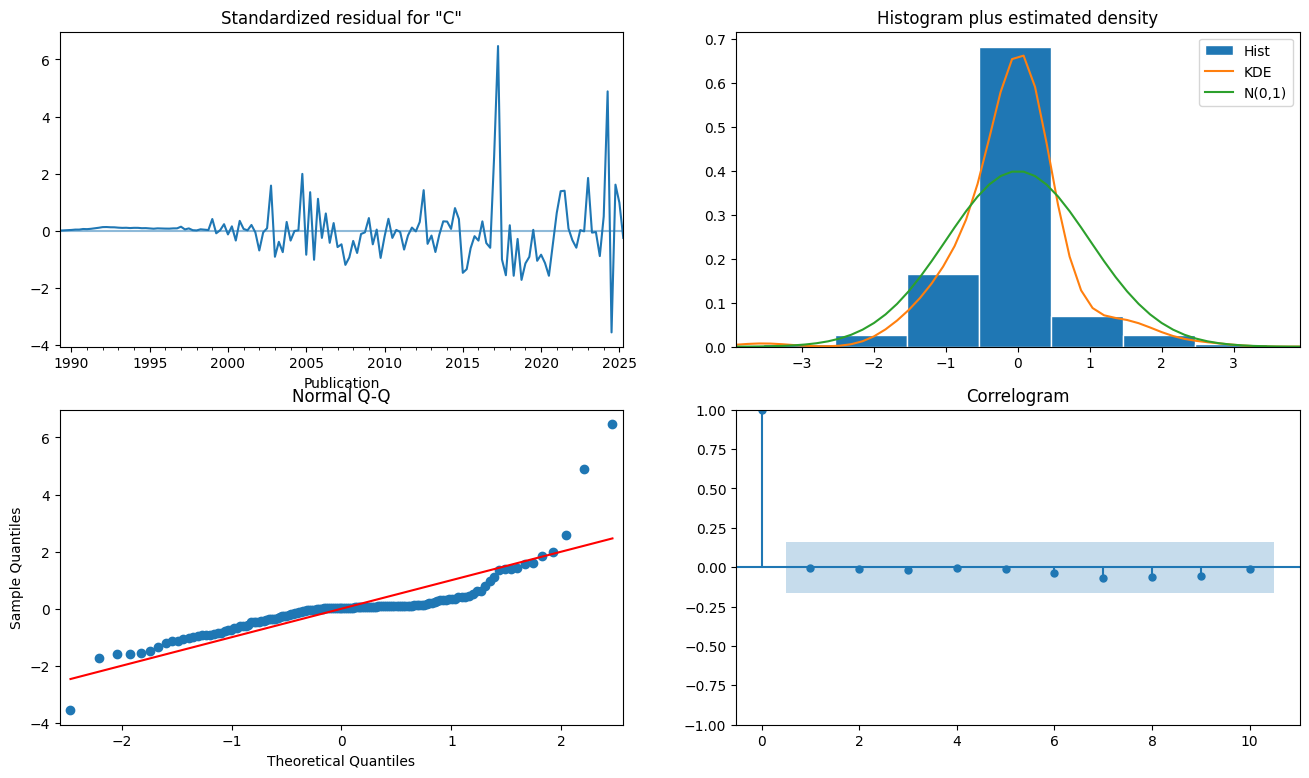

In [10]:
# Plot diagnostics
res.plot_diagnostics(figsize=(16, 9))
plt.show()

In [11]:
# Here we construct a more complete results object.
fcast_res1 = res.get_forecast(steps=4)

# Most results are collected in the `summary_frame` attribute.
# Alpha specifies the prediction interval we want in this forecast
# Note that this is different than the alpha in the graph which controls transperency
print(fcast_res1.summary_frame(alpha=0.05))

Count               mean     mean_se  mean_ci_lower  mean_ci_upper
2025-09-30  12497.807193  591.212678   11339.051637   13656.562748
2025-12-31  13047.795584  661.932070   11750.432566   14345.158602
2026-03-31  14135.229764  717.485277   12728.984462   15541.475067
2026-06-30  13975.909152  828.095611   12352.871579   15598.946726


In [12]:
today = date.today()
current_datetime = today.strftime("%b-%d-%Y")
#Note this format will overwrite all forecasts produced on the same day
file_name = current_datetime+"-Quarterly-vuln4cast.csv"
path = 'QuarterlyForecasts/'
# Check whether the specified path exists or not
isExist = os.path.exists(path)
if not isExist:
   # Create a new directory because it does not exist
   os.makedirs(path)
   print("The new directory is created!")
fcast_res1.summary_frame(alpha=0.05).to_csv(path+file_name)

In [13]:
df['v3 Vector'] = df['v3 Vector'].apply(remove_double_quotes)
df['v3 Vector'] = df['v3 Vector'].apply(remove_cvss_prefix)

In [14]:
mean_v3_vector_forecast = fcast_res1.summary_frame()['mean'].iloc[0]*df['v3 Vector'].value_counts(normalize=True)
lowerci_v3_vector_forecast = fcast_res1.summary_frame()['mean_ci_lower'].iloc[0]*df['v3 Vector'].dropna().value_counts(normalize=True)
upperci_v3_vector_forecast = fcast_res1.summary_frame()['mean_ci_upper'].iloc[0]*df['v3 Vector'].dropna().value_counts(normalize=True)

In [15]:
mean_v3_vector_forecast.to_csv(path+current_datetime+'-Quarterly-MeanV3VectorForecast.csv')
upperci_v3_vector_forecast.to_csv(path+current_datetime+'-Quarterly-UpperCIV3VectorForecast.csv')
lowerci_v3_vector_forecast.to_csv(path+current_datetime+'-Quarterly-LowerCIV3VectorForecast.csv')

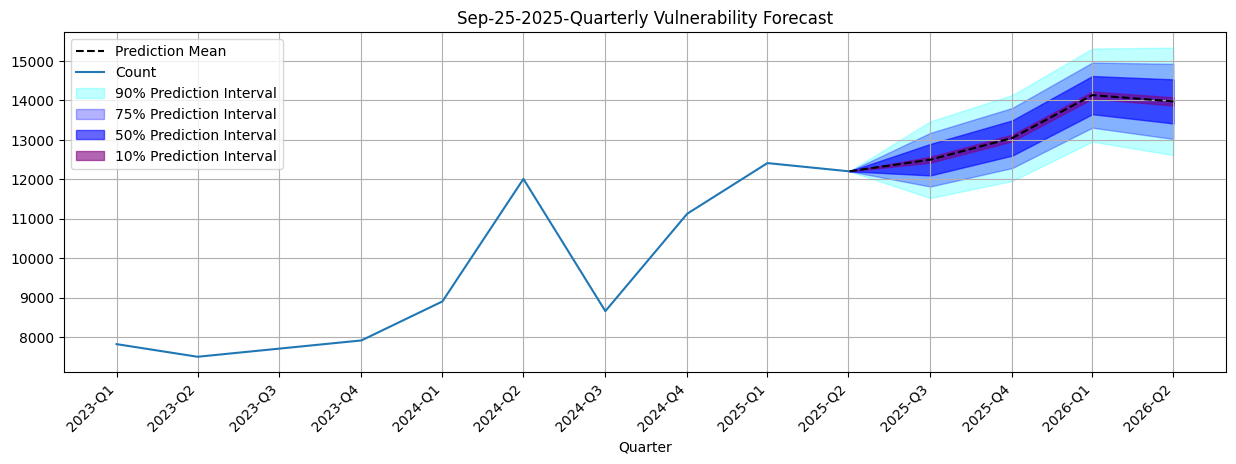

In [16]:
from pandas.tseries.offsets import QuarterEnd

fig, ax = plt.subplots(figsize=(15, 5))
plt.title(current_datetime+"-Quarterly Vulnerability Forecast")

# Plot the data (here we are subsetting it to get a closer look at the forecasts than the history)
quarterly_resample = df['Count'].resample('QE').sum()
# Construct the forecasts, this aplha controls the prediction intervals
fcast_10 = res.get_forecast(steps=4).summary_frame(alpha=0.10)
fcast_25 = res.get_forecast(steps=4).summary_frame(alpha=0.25)
fcast_50 = res.get_forecast(steps=4).summary_frame(alpha=0.50)
fcast_90 = res.get_forecast(steps=4).summary_frame(alpha=0.90)

# Calculate the start of the current quarter
current_date = pd.Timestamp.today()
current_quarter_start = pd.Timestamp(year=current_date.year, month=(current_date.quarter - 1) * 3 + 1, day=1)
interstitial_date = current_quarter_start.tz_localize(None)

new_row = pd.DataFrame(
    {'mean':[df.resample('QE').Count.sum().iloc[-1]], 
     'mean_se':[fcast_10['mean_se'].iloc[0]], 
     'mean_ci_lower':[df.resample('QE').Count.sum().iloc[-1]], 
     'mean_ci_upper':[df.resample('QE').Count.sum().iloc[-1]]}, 
    index=[interstitial_date])

fcast_10 = pd.concat([new_row, fcast_10])
fcast_10['mean'].plot(ax=ax, style='k--', label='Prediction Mean')

new_row = pd.DataFrame(
    {'mean':[df.resample('QE').Count.sum().iloc[-1]], 
     'mean_se':[fcast_25['mean_se'].iloc[0]], 
     'mean_ci_lower':[df.resample('QE').Count.sum().iloc[-1]], 
     'mean_ci_upper':[df.resample('QE').Count.sum().iloc[-1]]}, 
    index=[interstitial_date])

fcast_25 = pd.concat([new_row, fcast_25])

new_row = pd.DataFrame(
    {'mean':[df.resample('QE').Count.sum().iloc[-1]], 
     'mean_se':[fcast_50['mean_se'].iloc[0]], 
     'mean_ci_lower':[df.resample('QE').Count.sum().iloc[-1]], 
     'mean_ci_upper':[df.resample('QE').Count.sum().iloc[-1]]}, 
    index=[interstitial_date])

fcast_50 = pd.concat([new_row, fcast_50])

new_row = pd.DataFrame(
    {'mean':[df.resample('QE').Count.sum().iloc[-1]], 
     'mean_se':[fcast_90['mean_se'].iloc[0]], 
     'mean_ci_lower':[df.resample('QE').Count.sum().iloc[-1]], 
     'mean_ci_upper':[df.resample('QE').Count.sum().iloc[-1]]}, 
    index=[interstitial_date])

fcast_90 = pd.concat([new_row, fcast_90])

quarterly_resample.loc['2023Q1':].plot(ax=ax)
#This aplha is the one that controls transparency of a colour, not to be confused with the alpha that controls prediction intervals
ax.fill_between(fcast_10.index, fcast_10['mean_ci_lower'], fcast_10['mean_ci_upper'], color='cyan', alpha=0.25, label='90% Prediction Interval')
ax.fill_between(fcast_25.index, fcast_25['mean_ci_lower'], fcast_25['mean_ci_upper'], color='blue', alpha=0.30, label='75% Prediction Interval')
ax.fill_between(fcast_50.index, fcast_50['mean_ci_lower'], fcast_50['mean_ci_upper'], color='blue', alpha=0.60, label='50% Prediction Interval')
ax.fill_between(fcast_90.index, fcast_90['mean_ci_lower'], fcast_90['mean_ci_upper'], color='purple', alpha=0.60, label='10% Prediction Interval')
ax.grid(which='both')

# Add legend
ax.legend()

# Format x-axis for quarterly ticks
ticks = pd.date_range(start=quarterly_resample.index[-10].tz_localize(None), 
                     end=fcast_10.index[-1].tz_localize(None), 
                     freq='QE')
tick_labels = [f"{tick.year}-Q{tick.quarter}" for tick in ticks]

ax.set_xticks(ticks)
ax.set_xticklabels(tick_labels, rotation=45)
ax.set_xlabel("Quarter")  # Change label from Publication to Quarter
image_name = current_datetime+"-Quarterly-vuln4cast.png"
plt.savefig(path+image_name)

In [17]:
#We need an end date for the forecast verification data frame
end = fcast_res1.summary_frame(alpha=0.05).index[0]

In [18]:
if end.tz is None:
    end = end.tz_localize('UTC')

# Make check index timezone-aware before comparison
if verify:
    if check.index.tz is None:
        check = check.tz_localize('UTC')
    check = check[check.index < end]  # Now both sides are timezone-aware
print(fcast_res1.summary_frame(alpha=0.05))
if verify:
    print('The current count of published NVD vulns is: '+str(check['Count'].sum()))
    print('The current difference is: '+str(check['Count'].sum()- fcast_res1.summary_frame()['mean'].iloc[0]))

Count               mean     mean_se  mean_ci_lower  mean_ci_upper
2025-09-30  12497.807193  591.212678   11339.051637   13656.562748
2025-12-31  13047.795584  661.932070   11750.432566   14345.158602
2026-03-31  14135.229764  717.485277   12728.984462   15541.475067
2026-06-30  13975.909152  828.095611   12352.871579   15598.946726
The current count of published NVD vulns is: 11570
The current difference is: -927.8071925496006


In [19]:
mean_v3_vector_forecast = fcast_res1.summary_frame()['mean'].iloc[0]*df['v3 Vector'].dropna().value_counts(normalize=True)
lowerci_v3_vector_forecast = fcast_res1.summary_frame()['mean_ci_lower'].iloc[0]*df['v3 Vector'].dropna().value_counts(normalize=True)
upperci_v3_vector_forecast = fcast_res1.summary_frame()['mean_ci_upper'].iloc[0]*df['v3 Vector'].dropna().value_counts(normalize=True)

In [20]:
check['v3 Vector'] = check['v3 Vector'].astype(str).apply(remove_double_quotes)
check['v3 Vector'] = check['v3 Vector'].astype(str).apply(remove_cvss_prefix)
actual = check['v3 Vector'].value_counts()

In [21]:
predicted = mean_v3_vector_forecast

In [22]:
if len(actual) > 0: 
    mean_v3_vector_forecast = pd.merge(mean_v3_vector_forecast, actual, left_index=True, right_index=True, validate="1:1")
    mean_v3_vector_forecast = mean_v3_vector_forecast.rename(columns={"v3 Vector_x": "Predicted", "v3 Vector_y": "Actual"})
    lowerci_v3_vector_forecast = pd.merge(lowerci_v3_vector_forecast, actual, left_index=True, right_index=True, validate="1:1")
    lowerci_v3_vector_forecast = lowerci_v3_vector_forecast.rename(columns={"v3 Vector_x": "Predicted", "v3 Vector_y": "Actual"})
    upperci_v3_vector_forecast = pd.merge(upperci_v3_vector_forecast, actual, left_index=True, right_index=True, validate="1:1")
    upperci_v3_vector_forecast = upperci_v3_vector_forecast.rename(columns={"v3 Vector_x": "Predicted", "v3 Vector_y": "Actual"})

In [23]:
mean_v3_vector_forecast.to_csv('verify_quarterly_mean_v3_vector.csv')
lowerci_v3_vector_forecast.to_csv('verify_quarterly_ci_lower_v3_vector.csv')
upperci_v3_vector_forecast.to_csv('verify_quarterly_ci_upper_v3_vector.csv')

In [24]:
len(predicted)

1695

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=7acd54e3-f1e9-4bb5-a625-0a781a5b944c' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>